PREDICTING TOPICS OF HOTEL REVIEWS DATA(LATENT SEMANTIC ANALYSIS +KMEANS CLUSTERING)

In [7]:
#import libraries
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
import pandas as pd 
from nltk.tokenize import sent_tokenize
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD


In [8]:
#load in the data
hotel_reviews =pd.read_csv('Hotel_Reviews.csv')


In [9]:
hotel_reviews.shape

(7510, 25)

In [10]:
#look at the first few rows
hotel_reviews.head()

,id,dateAdded,dateUpdated,address,categories,primaryCategories,city,country,keys,latitude,longitude,name,postalCode,province,reviews.date,reviews.dateSeen,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,sourceURLs,websites
0,AVwc252WIN2L1WUfpqLP,2016-10-30T21:42:42Z,2018-09-10T21:06:27Z,5921 Valencia Cir,"Hotels,Hotels and motels,Hotel and motel reser...",Accommodation & Food Services,Rancho Santa Fe,US,us/ca/ranchosantafe/5921valenciacir/359754519,32.990959,-117.186136,Rancho Valencia Resort Spa,92067,CA,2013-11-14T00:00:00Z,"2016-08-03T00:00:00Z,2016-07-26T00:00:00Z,2016...",5.0,https://www.hotels.com/hotel/125419/reviews%20/,Our experience at Rancho Valencia was absolute...,Best romantic vacation ever!!!!,NaN,NaN,Paula,http://www.hotels.com/ho125419/%25252525253Flo...,http://www.ranchovalencia.com
1,AVwc252WIN2L1WUfpqLP,2016-10-30T21:42:42Z,2018-09-10T21:06:27Z,5921 Valencia Cir,"Hotels,Hotels and motels,Hotel and motel reser...",Accommodation & Food Services,Rancho Santa Fe,US,us/ca/ranchosantafe/5921valenciacir/359754519,32.990959,-117.186136,Rancho Valencia Resort Spa,92067,CA,2014-07-06T00:00:00Z,"2016-08-02T00:00:00Z,2016-08-26T00:00:00Z,2016...",5.0,https://www.hotels.com/hotel/125419/reviews%20/,Amazing place. Everyone was extremely warm and...,Sweet sweet serenity,NaN,NaN,D,http://www.hotels.com/ho125419/%25252525253Flo...,http://www.ranchovalencia.com
2,AVwc252WIN2L1WUfpqLP,2016-10-30T21:42:42Z,2018-09-10T21:06:27Z,5921 Valencia Cir,"Hotels,Hotels and motels,Hotel and motel reser...",Accommodation & Food Services,Rancho Santa Fe,US,us/ca/ranchosantafe/5921valenciacir/359754519,32.990959,-117.186136,Rancho Valencia Resort Spa,92067,CA,2015-01-02T00:00:00Z,"2016-11-15T00:00:00Z,2016-08-23T00:00:00Z,2016...",5.0,https://www.hotels.com/hotel/125419/reviews%20/,We booked a 3 night stay at Rancho Valencia to...,Amazing Property and Experience,NaN,NaN,Ron,http://www.hotels.com/ho125419/%25252525253Flo...,http://www.ranchovalencia.com
3,AVwdOclqIN2L1WUfti38,2015-11-28T19:19:35Z,2018-09-10T21:06:16Z,7520 Teague Rd,"Hotels,Hotels and motels,Travel agencies and b...",Accommodation & Food Services,Hanover,US,us/md/hanover/7520teaguerd/-2043779672,39.155929,-76.716341,Aloft Arundel Mills,21076,MD,2016-05-15T00:00:00Z,"2016-05-21T00:00:00Z,2016-07-31T00:00:00Z",2.0,https://www.tripadvisor.com/Hotel_Review-g4118...,Currently in bed writing this for the past hr ...,"Never again...beware, if you want sleep.",Richmond,VA,jaeem2016,http://www.yellowbook.com/profile/aloft-arunde...,http://www.starwoodhotels.com/alofthotels/prop...
4,AVwdOclqIN2L1WUfti38,2015-11-28T19:19:35Z,2018-09-10T21:06:16Z,7520 Teague Rd,"Hotels,Hotels and motels,Travel agencies and b...",Accommodation & Food Services,Hanover,US,us/md/hanover/7520teaguerd/-2043779672,39.155929,-76.716341,Aloft Arundel Mills,21076,MD,2016-07-09T00:00:00Z,2016-07-31T00:00:00Z,5.0,https://www.tripadvisor.com/Hotel_Review-g4118...,I live in Md and the Aloft is my Home away fro...,ALWAYS GREAT STAY...,Laurel,MD,MamaNiaOne,http://www.yellowbook.com/profile/aloft-arunde...,http://www.starwoodhotels.com/alofthotels/prop...


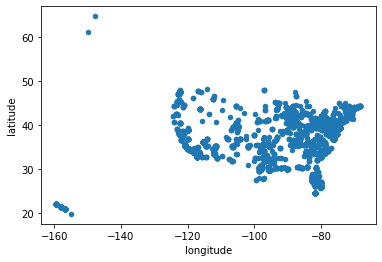

In [11]:
#plot the lats and longs of reviews
hotel_reviews.plot.scatter(x='longitude',y='latitude')

In [12]:
#grab the text column from our dataset
texts =hotel_reviews['reviews.text']

In [13]:
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [14]:
#tokenize the texts into sentences
import functools
sentences =functools.reduce(lambda x, y:x+y,texts.apply(lambda x:sent_tokenize(str(x))))

In [15]:
#check how many sentences are present in texts
len(sentences)

35727

In [16]:
#create a document-term matrix with TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(ngram_range =(1,2),stop_words ='english')
tfidf_transformed =tfidf.fit_transform(sentences)
tfidf_transformed

<35727x124010 sparse matrix of type '<class 'numpy.float64'>'
	with 389733 stored elements in Compressed Sparse Row format>

In [17]:
#apply singular value decomposition to extract 10 topics
svd=TruncatedSVD(n_components=10)


In [18]:
#apply normalizer to give each document a unit norm
normalizer =Normalizer()

In [19]:
#create a scikitlearn pipeline to perform LSA
from sklearn.pipeline import Pipeline
lsa =Pipeline(steps=[('tfidf',tfidf),('svd',svd),('normalizer',normalizer)])

In [20]:
#fit and transform or sentences
lsa_sentences =lsa.fit_transform(sentences)

In [21]:
lsa_sentences.shape

(35727, 10)

In [22]:
#apply kmeans to our lsa_sentences
cluster =KMeans(n_clusters=10)
cluster.fit(lsa_sentences)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [23]:
cluster.transform(lsa_sentences).shape

(35727, 10)

In [24]:
predicted_cluster =cluster.predict(lsa_sentences)

In [26]:
#distribution of topics
pd.Series(predicted_cluster).value_counts(normalize=True)
#create dataframe of texts and predicted topics 
texts_df =pd.DataFrame({'text':sentences,'topic':predicted_cluster})

In [27]:
texts_df.head()


,text,topic
0,Our experience at Rancho Valencia was absolute...,5
1,We felt special and very happy during our stayed.,9
2,I would come back in a heart beat!!,9
3,!,4
4,Amazing place.,8


In [28]:
print ("Top terms per cluster:")
original_space_centroids =svd.inverse_transform(cluster.cluster_centers_)
order_centroids =original_space_centroids.argsort()[:,::-1]

terms=lsa.steps[0][1].get_feature_names()
for i in range (10):
  print("Cluster %d:"%i)
  print (', '.join([terms[ind] for ind in order_centroids[i,:5]]))

lsa.steps[0][1]

Top terms per cluster:
Cluster 0:
room, hotel, bad, breakfast, great
Cluster 1:
breakfast, good, bad, breakfast good, great
Cluster 2:
room, room clean, bad, clean, room nice
Cluster 3:
staff, friendly, staff friendly, helpful, friendly helpful
Cluster 4:
nice, room, hotel, nice hotel, room nice
Cluster 5:
location, good, hotel, good location, great
Cluster 6:
stay, definitely, definitely stay, hotel, enjoyed
Cluster 7:
clean, comfortable, rooms, clean comfortable, bed
Cluster 8:
great, great location, location, breakfast, hotel
Cluster 9:
hotel, recommend, bad, recommend hotel, definitely


TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [29]:
print(cluster.predict(lsa.transform(['I definitely recommend this hotel'])))
print(cluster.predict(lsa.transform(['Super Friendly staff.Love it'])))

[9]
[3]
